**탐색적 분석**

In [1]:
import pandas as pd

# 데이터 경로
data_path = './input/'

sales_train = pd.read_csv(data_path + 'sales_train.csv')
shops = pd.read_csv(data_path + 'shops.csv')
items = pd.read_csv(data_path + 'items.csv')
item_categories = pd.read_csv(data_path + 'item_categories.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [2]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


1. 월별 판매량을 구해야 하니 '월' 구분자만 있으면 됨
2. 2013.01.02 에 판매가(당시 판매가 999루블) 가격이 고정된게 아니라 시간이 지남에 따라 바뀔수 있다.
3. 각 상점의 상품별 일일 판매량을 월별로 합친게 월간 판매량임 
4. block_num => 2013.01월 : 0 , 2015.10월 : 34

In [3]:
# 비결측값 갯수를 표시하기 위해 show_counts = True 표시
print(f"sales train 행의 갯수 : {len(sales_train)}")
sales_train.info(show_counts=True)

sales train 행의 갯수 : 2935849
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date            2935849 non-null  object 
 1   date_block_num  2935849 non-null  int64  
 2   shop_id         2935849 non-null  int64  
 3   item_id         2935849 non-null  int64  
 4   item_price      2935849 non-null  float64
 5   item_cnt_day    2935849 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


1. 데이터가 300만개 가까이 되어서 메모리 134MB 임 -> 메모리사용량 줄일계획
2. 시계열 데이터는 시간흐름이 중요하므로 2013 1월부터 2015 9월까지 판매내역 훈련데이터로 사용하고
   2015 10월 판매내역 검증데이터로 사용하겠음
3. 앞장의 OOF 예측 은 시계열 데이터에서 사용할시 과거와 미래가 뒤섞이기 때문에 이용할수없다 ㅠ 

In [4]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


1. 러시아어 공부 시작할순 없음
2. 다른 캐글러가 공유한 아이디어 활용할예정
3. 좀 복잡해보이니 베이스라인 짜고 성능개성 한 이후에 다룰 예정
4. 결론부터 미리 말하면 첫단어는 도시 나타냄

In [5]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


상점은 딱 60 개 정도 있고 , 결측값도 없고 데이터 개수가 적어서 메모리 사용량도 적다

In [6]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


item_id 를 기준으로 slaes_train 과 item 병합이 가능할거같다. 

In [7]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [8]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


1. category ID 기준으로 병합 가능할거같음
2. 상품분류명의 첫단어는 대분류를 뜻함 
3. 베이스 라인 끝내고 추후 피처 엔지니어링시 대분류 피처로 만들수있을듯 

병합 계획
1. sales_train 과 shops -> shop_id 기준으로 병합
2. sales_train 과 items -> item_id 기준으로 병합
3. sales_train 과 item_categories  -> item_category_id 기준으로 병합 (2번 이후에 itemcategory id 생김)

In [11]:
train = sales_train.merge(shops, on='shop_id', how='left')
train = train.merge(items, on='item_id', how='left')
train = train.merge(item_categories, on='item_category_id', how='left')

train.head().T

,0,1,2,3,4
date,02.01.2013,03.01.2013,05.01.2013,06.01.2013,15.01.2013
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999.0,899.0,899.0,1709.05,1099.0
item_cnt_day,1.0,1.0,-1.0,1.0,1.0
shop_name,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""
item_name,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE Who Do You Think We Are LP,DEEP PURPLE 30 Very Best Of 2CD (Фирм.)
item_category_id,37,58,58,58,56
item_category_name,Кино - Blu-Ray,Музыка - Винил,Музыка - Винил,Музыка - Винил,Музыка - CD фирменного производства


In [12]:
def resumetable(df):
    print(f'데이터셋 형상 : {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index' : '피처'})
    summary['결측값 개수'] = df.isnull().sum().values
    summary['고유값 개수'] = df.nunique().values
    summary['첫 번째 값'] = df.loc[0].values
    summary['두 번째 값'] = df.loc[1].values
    
    return summary

resumetable(train)
    

데이터셋 형상 : (2935849, 10)


,피처,데이터 타입,결측값 개수,고유값 개수,첫 번째 값,두 번째 값
0,date,object,0,1034,02.01.2013,03.01.2013
1,date_block_num,int64,0,34,0,0
2,shop_id,int64,0,60,59,25
3,item_id,int64,0,21807,22154,2552
4,item_price,float64,0,19993,999.0,899.0
5,item_cnt_day,float64,0,198,1.0,1.0
6,shop_name,object,0,60,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум"""
7,item_name,object,0,21807,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP
8,item_category_id,int64,0,84,37,58
9,item_category_name,object,0,84,Кино - Blu-Ray,Музыка - Винил


1. 결측값은 하나도 없음
2. 고유값 갯수 같은쌍들 (shop_id, shop_name) , (item_id, item_name) , (item_category_id,item_category_name)  
3. 2번내용을 토대로 id 와 name 은 둘중 하나만 있어도 될거같음  
4. name 같은 경우에는 파생피처를 만들수 있을거같음   

<AxesSubplot:ylabel='item_cnt_day'>

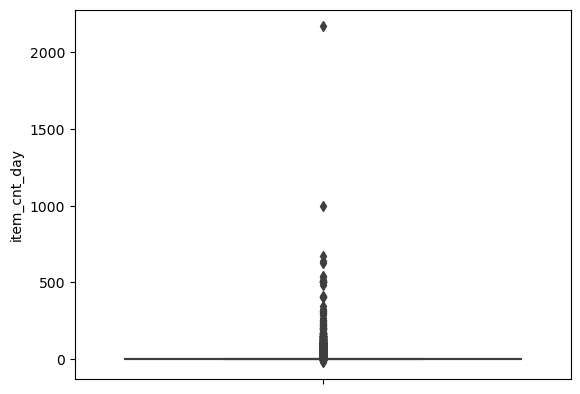

In [14]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

sns.boxplot(y='item_cnt_day', data=train)

박스플롯에서 이상치범위가 과도하게 넓어서 1사분위 2사분위, 3사분위를 나타내는 박스모양 납작해짐  
1000이상인거는 제거할예정

<AxesSubplot:ylabel='item_price'>

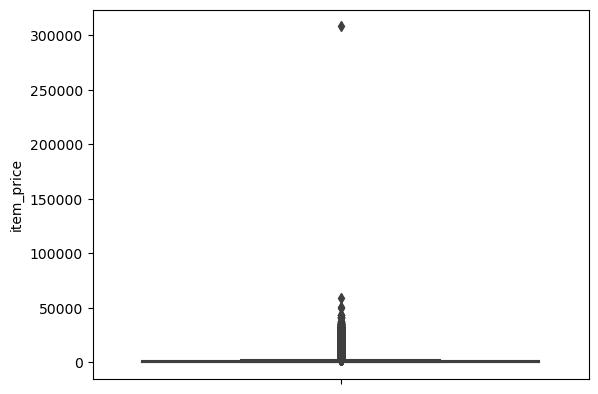

In [15]:
sns.boxplot(y='item_price', data=train)

50000루블 이상인거는 제거할예정

In [17]:
group = train.groupby('date_block_num').agg({'item_cnt_day':'sum'})
group.reset_index().head()

,date_block_num,item_cnt_day
0,0,131479.0
1,1,128090.0
2,2,147142.0
3,3,107190.0
4,4,106970.0


[Text(0.5, 1.0, 'Distribution of monthly item counts by date block number'),
 Text(0.5, 0, 'Date block number'),
 Text(0, 0.5, 'Monthly item counts')]

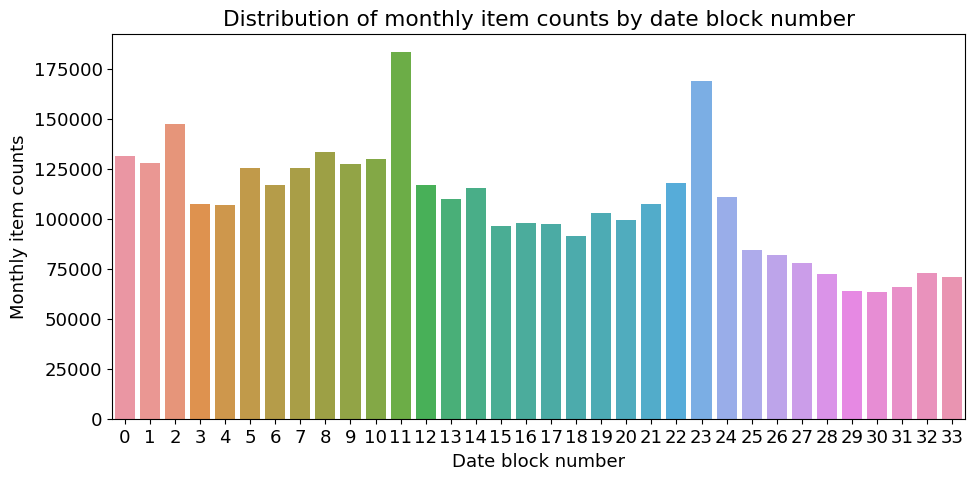

In [20]:
# 월별 판매량 세팅
mpl.rc('font', size=13)
figure, ax = plt.subplots()
figure.set_size_inches(11, 5) # 가로 11, 세로5

# 월별 총 상품 판매량
group_month_sum = train.groupby('date_block_num').agg({'item_cnt_day': 'sum'})
group_month_sum = group_month_sum.reset_index()

# 월별 총 상품 판매량 막대 그래프
sns.barplot(x='date_block_num', y='item_cnt_day', data=group_month_sum)
# 그래프 제목, x축 라벨, y축 라벨명 설정
ax.set(title='Distribution of monthly item counts by date block number',
       xlabel='Date block number',
       ylabel='Monthly item counts')

In [21]:
train['item_category_id'].nunique()

84

84개는 막대그래프로 표현하기에 너무 많으니 판매량이 10000개를 초과하는 상품 분류만 추출해서 그려보겠음

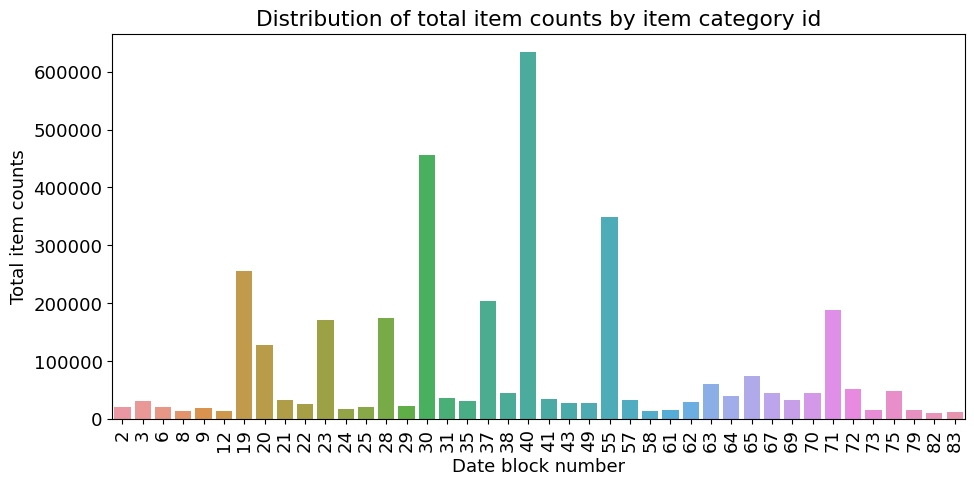

In [22]:
figure, ax = plt.subplots()
figure.set_size_inches(11, 5)

# 상품분류별 총 상품 판매량
group_cat_sum = train.groupby('item_category_id').agg({'item_cnt_day' : 'sum'})
group_cat_sum = group_cat_sum.reset_index()

# 월간 판매량이 10000개를 초과하는 상품분류만 추출
group_cat_sum = group_cat_sum[group_cat_sum['item_cnt_day']>10000]

# 상품분류별 총 상품 판매량 막대 그래프
sns.barplot(x='item_category_id', y='item_cnt_day', data=group_cat_sum)
ax.set(title='Distribution of total item counts by item category id',
       xlabel='Date block number',
       ylabel='Total item counts')

ax.tick_params(axis='x', labelrotation=90)

40번인 상품이 가장 많이 팔림, 30번하고 55번이 그뒤를 이음

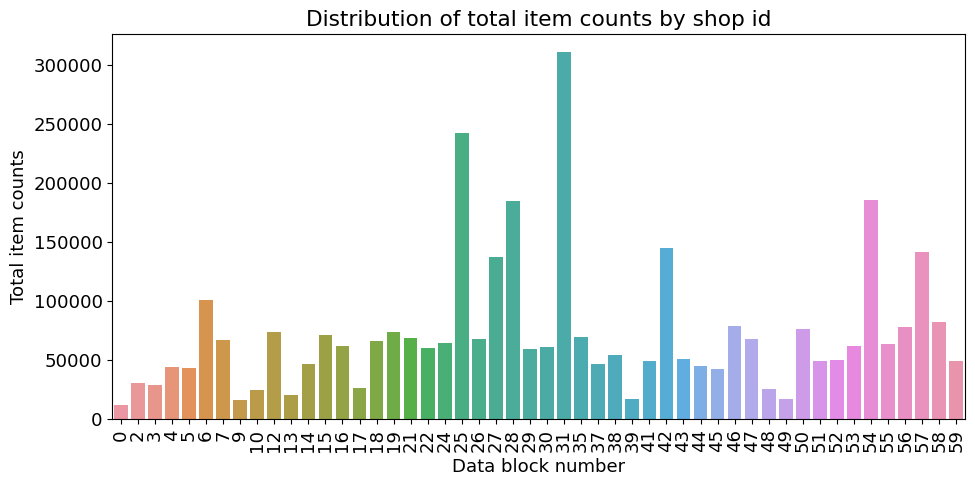

In [24]:
# 상점별 월간 판매량 살펴보자
# 이것도 한번에 그리기 머해서 판매량 10000개 초과하는것만 추리자

figure, ax = plt.subplots()
figure.set_size_inches(11, 5)

# 상점별 총 상품 판매량
group_shop_sum = train.groupby('shop_id').agg({'item_cnt_day' : 'sum'})
group_shop_sum = group_shop_sum.reset_index()

group_shop_sum = group_shop_sum[group_shop_sum['item_cnt_day'] > 10000]

# 상점별 총 상품 판매량 막대 그래프
sns.barplot(x='shop_id', y='item_cnt_day', data=group_shop_sum)
ax.set(title='Distribution of total item counts by shop id',
       xlabel='Data block number',
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90)

**분석 정리**

1. OOF 등 데이터 순서가 무시되는 기법 사용할수없음
2. 검증데이터는 마지막 1개월치 이용
3. 일별 판매량 합쳐서 타깃값 구해야함
4. 상점 ID, 상품 ID, 상품 분류 ID 기준으로 훈련데이터 병합 가능
5. 메모리 관리하자
6. 파생피처 추가 -> 상점명과 상품분류명의 첫단어 도시와 대분류 
7. 일별 피처제거 (date 피처 제거)
8. ID 와 이름 1대1 대응이므로 둘중 하나만 남김 (상점명, 상품명, 상품 분류명)
9. 이상치 제거 (일별판매량 과 판매가의 이상치 제거)
10. 모든 데이터에는 결측값 없음

** 모델링 전략 **

베이스라인 모델 : LightGMB
 - 피처 엔지니어링 : 피처명 한글화, 데이터 다운캐스팅, 데이터 조합 생성, 타깃값 추가

성능 개선 전략: LightGBM 유지
 - 피처 엔지니어링 : 이상치 제거, 저너리 등 다양한 파생 피처 추가, 인코딩, 결측값 처리